In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

# Optimization versus Generalization

* We have found classification and regression models by minimizing an average loss across training examples.

* In other words, we have found models by solving optimization problems.

* However, recall that minimizing the loss was not the *ultimate* objective, but a *surrogate* objective.

* The ultimate objective was always finding a model that generalizes well (makes good predictions on unseen data).

# Training, validation, and testing datasets

* Training neural networks generally requires three datasets: training dataset, validation dataset, and testing dataset. These three datasets may be obtained by partitioning an original dataset into smaller datasets.

* The **training dataset** enables training different neural networks, each with different hyperparmeters (such as learning rate, batch size, initialization, architecture, and optimization algorithm).

* Parameters are specialized for a training dataset.

* However, a model that performs very well on the training dataset may perform poorly on unseen data. This is called *overfitting*.

* A model that does not perform well even on the training dataset is said to be *underfitting*.

* The **validation dataset** enables assessing the performance of different neural networks on unseen data. This ultimately enables maximizing validation dataset performance with respect to hyperparameters.

* Hyperparameters are specialized for a validation dataset.

* However, hyperparameters that perform very well on the validation dataset may perform poorly on unseen data. This is also called overfitting.

* The **testing dataset** enables estimating the performance of the final hyperparameter settings.

* The hyperparameters that maximize validation dataset performance should be used to train a new neural network on the (combined) training and validation datasets. The performance of this neural network on the test dataset can be a reliable indicator of the performance on unseen data.

* Neither parameters nor hyperparameters are specialized for a test dataset, since the testing dataset is only used to evaluate the outcome of hyperparameter tuning.

* **Changing hyperparmeters based on their performance on the testing dataset defeats its purpose**.

# Early Stopping

* The simplest heuristic to prevent overfitting involves stopping the training procedure if the loss on the validation dataset keeps increasing instead of decreasing. This is called early stopping.

* The number of epochs during which the validation loss is allowed to not decrease is called *patience*.

![Early stopping.](https://drive.google.com/uc?export=view&id=1Ot5PJzEgtKbcRF1LvFP_ZE9v3C_zuoBN)

# Data Augmentation

* In order to improve generalization, it is often possible to *augment* the training dataset with additional examples that are derived from the existing examples.

* This is one way to improve neural network performance using domain knowledge.

* For example, a neural network trained to classify pictures of cats or dogs should be able to classify all of the following variants derived from an existing example:

![Data augmentation.](https://drive.google.com/uc?export=view&id=10od51l_n0WGBfiOkpyA4UAlSSXnKNBYq)



# Learning Rate

* The learning rate is often a crucial hyperparameter.

* In order to guarantee that gradient descent decreases the loss (or at least not increases the loss), the learning rate should be infinitesimally small. However, this would make gradient descent move too slowly for practical purposes.

* The following code illustrates the path taken by gradient descent to minimize a function $f$ given by $f(x) = x^2$.


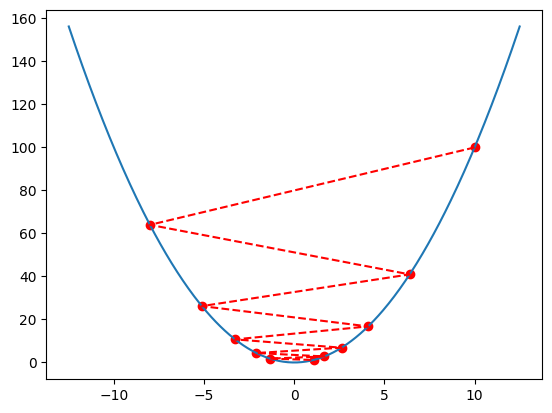

In [5]:
# You should experiment with different learning rates (for example: 0.1, 0.9, 1.0)
f = lambda x: x**2  # Loss function
gradf = lambda x: 2 * x  # Gradient function

def gradient_descent(init=10, lr=0.2, iterations=10):
    x = init
    path = [init]

    for i in range(iterations):
        x -= lr * gradf(x)
        path.append(x)

    return path

def show_path(min_x, max_x, path):
    xs = torch.linspace(min_x, max_x, 400)
    ys = f(xs)

    path_y = [f(x) for x in path]

    plt.plot(xs, ys)
    plt.scatter(path, path_y, color='red')
    plt.plot(path, path_y, color='red', linestyle='--')

    plt.show()

init = 10
lr = 0.9
iterations = 10

path = gradient_descent(init, lr, iterations)
show_path(- 1.25 * init, 1.25 * init, path)

* A common heuristic is to start with a learning rate that is as high as possible (without causing instability) and then decrease it during the training process.

* We will soon use optimization methods that *adapt* the initial learning rate during the training process.


# Parameter Initialization

* Recall that gradient descent requires initializing the parameters of the neural network before computing the gradient of the loss with respect to the parameters for the first time.

* The parameters of a multilayer perceptron should not all be initialized as a constant (such as zero), because they would remain equal during gradient descent under typical conditions. Random initialization naturally breaks this *symmetry*.

* Although neural network parameters can be initialized (mostly) arbitrarily, the parameter initialization method has a significant impact on the performance of gradient descent.

* Parameter initialization has been widely studied. Popular initialization methods for weight matrices typically take into account the number of units in the previous layer, the number of units in the current layer, and the activation function of the current layer.

* PyTorch implements several popular parameter initialization methods in the module `torch.nn.init`.

* **Note: `torch.nn.Linear` layers organize weight matrices so that the number of units in the previous layer corresponds to the number of columns, and the number of units in the current layer corresponds to the number of rows. In comparison with our notation, these weight matrices are transposed.**


## Xavier Initialization

* Proposed in *Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)*. Also known as Glorot initialization.

* Assuming a $\text{ReLU}$ activation function, each weight is sampled from a normal distribution with standard deviation $\sigma$ given by
$$ \sigma = \sqrt{\frac{4}{n_i + n_o}},$$
where $n_{i}$ denotes the number of units in the previous layer and $n_{o}$ denotes the number of units in the current layer.

* This initialization method is implemented by `torch.nn.init.xavier_normal_`.


In [ ]:
w = torch.empty(3, 4)
torch.nn.init.xavier_normal_(w, gain=torch.nn.init.calculate_gain('relu'))
print(w)

tensor([[-0.0295, -0.1366,  1.0864,  1.4607],
        [ 0.5324,  0.1879, -0.1534,  1.1630],
        [ 2.0545,  0.5259, -0.0725, -0.0482]])


## Kaiming Initialization

* Proposed in *Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)*. Also known as He initialization.

* Assuming a $\text{ReLU}$ activation function, each weight is sampled from a normal distribution with standard deviation $\sigma$ given by
$$ \sigma = \sqrt{\frac{2}{n}},$$
where $n$ is either the number of units in the previous layer or the number of units in the current layer.

* This initialization method is implemented by `torch.nn.init.kaiming_normal_`.


In [ ]:
w = torch.empty(3, 4)
torch.nn.init.kaiming_normal_(w, a=0, mode='fan_in', nonlinearity='relu')
print(w)

tensor([[-0.1980,  1.9853, -0.6065, -0.2294],
        [-1.3341,  0.1011,  0.3142, -0.7580],
        [-0.1400, -0.4961, -0.3247,  0.2156]])


# Regularization

* Regularization techniques are intended to reduce overfitting.

* Some authors consider early stopping and data augmentation as regularization techniques.

* We will cover two additional techniques: weight decay and dropout.

## Weight decay

* **Weight decay** is a traditional regularization technique that can also be used with linear models, where it is often called $L_2$-regularization.

* If all the weights of a neural network are concatenated into a weight vector $\mathbf{w}$, then weight decay adds the (squared $L_2$) norm of $\mathbf{w}$ times a constant to the original loss $L$, so that the objective becomes minimizing
$$ L + \frac{\lambda}{2} \| \mathbf{w} \|^2,$$
where $\lambda \geq 0$ is a hyperparameter.

* Weight decay penalizes the weights for being large in magnitude (very negative or very positive).

* Intuitively, this penalizes having outputs that are very sensitive to small changes in the input.

* The stochastic gradient descent optimizer `torch.optim.SGD` accepts $\lambda$ as a parameter (called `weight_decay`).

## Droupout

* Dropout is a heuristic for training neural networks that intends to reduce overfitting.

* At every iteration of stochastic gradient descent, half the hidden neurons are removed at random and the remaining neurons have their output doubled.

* This modified network is applied to the observations in a batch, and the gradient of the loss with respect to the parameters is computed as usual.

* The corresponding update will only change parameters of neurons that were not removed.

* This heuristic is believed to make the network robust to the absence of particular combinations of features (detected by particular units), which might be particular to the training dataset.

* Instead of always removing half the neurons, dropout implementations typically allow removing a fraction $p \in [0, 1]$ of the neurons, which requires scaling the output of the remaining neurons by $1/(1 - p)$.

* Dropout is only deployed during training, not for computing predictions.

![Dropout.](https://drive.google.com/uc?export=view&id=1rf5SkkvKzBS5mD55j3yqHNF4FqA-cahT)


### Simple implementation

* The following code implements a *dropout layer*. The matrix `x` is a batch of input vectors or feature vectors, each of which corresponds to a row.



In [ ]:
def dropout_layer(x, p):
    if p == 1: # Drops all elements
        return torch.zeros_like(x)
    if p == 0:
        return x # Keeps all elements
    mask = (torch.Tensor(x.shape).uniform_(0, 1) > p).float() # Samples a matrix whose elements are either one or zero.
    return mask * x / (1.0 - p) # Masks `x` and scales the remaining elements to compensate.

x = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=torch.float)
print(x)
x = dropout_layer(x, 0.5)
print(x)

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])
tensor([[ 2.,  0.,  0.,  8.],
        [10.,  0., 14.,  0.]])


### PyTorch implementation

* The following code uses the layer `torch.nn.Dropout`, which implements dropout in PyTorch.

* This layer would typically be applied after each hidden layer in a multilayer perceptron.

* In order to prevent dropout outside the training process, it is necessary to call the method `eval` to put the `nn.torch.Module` object in evaluation mode.

* In order to resume dropout during the training process, it is necessary to call the method `train` to put the `nn.torch.Module` object in training mode.

In [ ]:
dropout_layer = torch.nn.Dropout(p=0.5)
x = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=torch.float)
print(x)
print()

print(dropout_layer(x))
print()

dropout_layer.eval() # Prevents dropout for evaluation
print(dropout_layer(x))
print()

dropout_layer.train() # Resumes dropout for training
print(dropout_layer(x))

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])

tensor([[ 2.,  0.,  6.,  8.],
        [ 0., 12.,  0.,  0.]])

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])

tensor([[ 2.,  4.,  0.,  0.],
        [10., 12.,  0., 16.]])



# Recommended reading

* [Dive into Deep Learning](https://d2l.ai): Chapters 5.4, 5.5, and 5.6.

# [Storing this notebook as a `pdf`]

* In order to store this notebook as a pdf, you will need to hide the images included in the previous cells using the following syntax:
    * `<!--- ![Image caption.](https://link.to.image) --->`

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

# Set the path to this notebook below (add \ before spaces). The output `pdf` will be stored in the corresponding folder.
!jupyter nbconvert --to pdf /content/gdrive/My\ Drive/Colab\ Notebooks/nndl/week_06/lecture/01_Training_Techniques.ipynb

# If having issues, save this notebook (File > Save) and restart the session (Runtime > Restart session) before running this cell. To debug, remove the first line (`%%capture`).